# 3D (x-y-t) field inference: 2 platforms (Nxy=2), separation sensitivity (dx)


In [1]:
import os
from tqdm import tqdm
#import pickle

import numpy as np
import pandas as pd
import xarray as xr
import dask

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

import corner
import arviz as az

import nwatools.stats as st
colors = st.colors
day = 86400

#data_dir = "data/"
#data_dir = "/home1/scratch/aponte/"
data_dir = "/home/datawork-lops-osi/aponte/nwa/drifter_stats"

/home1/datawork/aponte/miniconda3/envs/equinox/lib/python3.10/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/home1/datawork/aponte/miniconda3/envs/equinox/lib/python3.10/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


ERROR 1: PROJ: proj_create_from_database: Open of /home1/datawork/aponte/miniconda3/envs/equinox/share/proj failed


In [2]:
# actually run production inferences
#prod=True
#prod=False

local_cluster = True
#if prod:
#    local_cluster = False

if local_cluster:
    from dask.distributed import Client, LocalCluster
    cluster = LocalCluster()
else:
    from dask.distributed import Client, LocalCluster
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster(cores=20, processes=20, walltime="03:00:00")
    #cluster = PBSCluster(cores=7*2, processes=7*2, walltime="03:00:00")
    #cluster = PBSCluster(cores=7*2, processes=7*2, walltime="00:30:00")
    # cores=7, processes=7, 02:00:00 by default
    w = cluster.scale(jobs=5)

client = Client(cluster)
client

/home1/datawork/aponte/miniconda3/envs/equinox/lib/python3.10/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/home1/datawork/aponte/miniconda3/envs/equinox/lib/python3.10/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/home1/datawork/aponte/miniconda3/envs/equinox/lib/python3.10/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/home1/datawork/aponte/miniconda3/envs/equinox/lib/python3.10/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.comm.recent-message

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 56,Total memory: 100.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40504,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 56
Started: Just now,Total memory: 100.00 GiB
Comm: tcp://127.0.0.1:46881,Total threads: 7
Dashboard: http://127.0.0.1:38754/status,Memory: 12.50 GiB
Nanny: tcp://127.0.0.1:60447,


## Prepare distribution of computations

Computations to be distributed:

- Fixed station inference
- Lagrangian simulation and inference


In [3]:
# flow case
U = "0.1"
#case = "3D_matern32_iso_matern12_pp_r0.0_u"+U
case = "3D_matern52_iso_matern12_pp_r0.0_u"+U
run_dir = os.path.join(data_dir, case)

uv = True # True if u and v are observed
parameter_eta_formulation = False # eta vs nu formulation
noise = 0.01 # observation noise added to u/v
no_time = False # activates time inference
no_space = False
traj_decorrelation = False  # artificially decorrelate different moorings/drifters
#traj_decorrelation = True  # artificially decorrelate different moorings/drifters

# number of points used for inference#
#Nxy, Nt = 1, 50
Nxy, Nt = 2, 50
#Nxy, Nt = 5, 50
#Nxy, Nt = 10, 50

# run multiple Nxy at once
#Nxy = [1, 2, 4, 8, 16]

# number of ensembles
#Ne = 10 # dev
Ne = 100 # prod

dx = None
#dx = 100. # Nxy>1, separation between platforms
#dx = [20, 50, 100, 150, 200]
dx = [10, 20, 30, 40, 50, 60, 80, 100, 125, 150, 175, 200, 300]
#dx = [5, 10, 20, 30, 40, 50, 60, 80, 100, 125, 150, 175, 200, 300]

burn = 500 # number of samples to drop (burning)

### prepare inference & common utils

In [4]:
dsf, covfunc, covparams, labels = st.prepare_inference(
    run_dir,
    uv, no_time, no_space,
    parameter_eta_formulation, traj_decorrelation,
)
flow_attrs = dict(**dsf.attrs)
truth = {k: v for k, v in zip(labels, [noise]+covparams)}

U 0.1
amplitude0 7.745966692414835
amplitude1 0.0
cov_t matern12
cov_x matern52_iso
cov_y matern52_iso
eta 7.745966692414835
kind pp
lambda_t 5
lambda_x 100
lambda_y 100
nu_space 2.5
nu_time 0.5
noise 0.0
pp_ratio 0.0
dx 2.0
dy 2.0


---

## run/load inferences

### moorings

In [5]:
def load_mooring(Nxy, dx):    
    print(Nxy, dx)
    
    # build output file name
    nc = os.path.join(run_dir, f"moorings_ensemble_Nxy{Nxy}.nc")
    if dx is not None:
        nc = nc.replace(".nc", f"_dx{dx:0.0f}.nc")
    if traj_decorrelation:
        nc = nc.replace(".nc", f"_trajd.nc")

    ds = xr.open_dataset(nc)
    ds["parameter"] = ds.parameter.astype(str)

    # move noise last
    ds = ds.sel(parameter=['γ', 'λx', 'λt', 'σ'])

    return ds

Dm = []
for d in dx:
    Dm.append(load_mooring(Nxy, d))

2 10
2 20
2 30
2 40
2 50
2 60
2 80
2 100
2 125
2 150
2 175
2 200
2 300


### drifters

In [6]:
# wrapper
def load_drifter(Nxy, dx):
    print(Nxy, dx)

    # build output file name    
    nc = os.path.join(run_dir, f"drifters_ensemble_Nxy{Nxy}.nc")
    if dx is not None:
        nc = nc.replace(".nc", f"_dx{dx:0.0f}.nc")
    if traj_decorrelation:
        nc = nc.replace(".nc", f"_trajd.nc")

    ds = xr.open_dataset(nc)
    ds["parameter"] = ds.parameter.astype(str)

    # move noise last
    ds = ds.sel(parameter=['γ', 'λx', 'λt', 'σ'])
    
    return ds

Dr = []
for d in dx:
    Dr.append(load_drifter(Nxy, d))

2 10
2 20
2 30
2 40
2 50
2 60
2 80
2 100
2 125
2 150
2 175
2 200
2 300


---

## results summary - joint mooring/drifters plots

In [7]:
def _pprocess(ds, dx):
    ds = ds.copy()
    #print(ds["flow_scale"])
    for v in ["true_parameters", "survival_rate"]:
        if v in ds:
            ds[v] = ds[v].isel(ensemble=0)
    #ds["U"] = float(U) * ds.flow_scale
    #λt = float(ds["true_parameters"].sel(parameter="λt"))
    #λx = float(ds["true_parameters"].sel(parameter="λx"))
    ds["dx"] = dx
    ds["dx"].attrs.update(unit=["km"])
    ds = (ds
    #  .assign_coords(α = ds["U"] * λt*day/(λx*1e3))
      .set_coords("true_parameters")
    )
    ds.attrs.update(**flow_attrs)
    return ds

dsm = xr.concat([_pprocess(d, _dx) for d, _dx in zip(Dm,dx)], "dx")
dsr = xr.concat([_pprocess(d, _dx) for d, _dx in zip(Dr,dx)], "dx")

In [8]:
bounds = dict(
    σ=(-.002,.041),
    γ=(0.5*truth["γ"],1.5*truth["γ"]),
    #λx=(-10,350),
    λx=(-10,200),
    #λt=(2,13),
    λt=(2,10),
)
# common kwargs
kw = dict(x="dx", x_off=5., x_width=5., bounds=bounds)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


scp dunree:/home1/datawork/aponte/code/nwa/stats/figs/matern52_iso_dx_MAP.eps .
scp dunree:/home1/datawork/aponte/code/nwa/stats/figs/matern52_iso_dx_MAP.png .


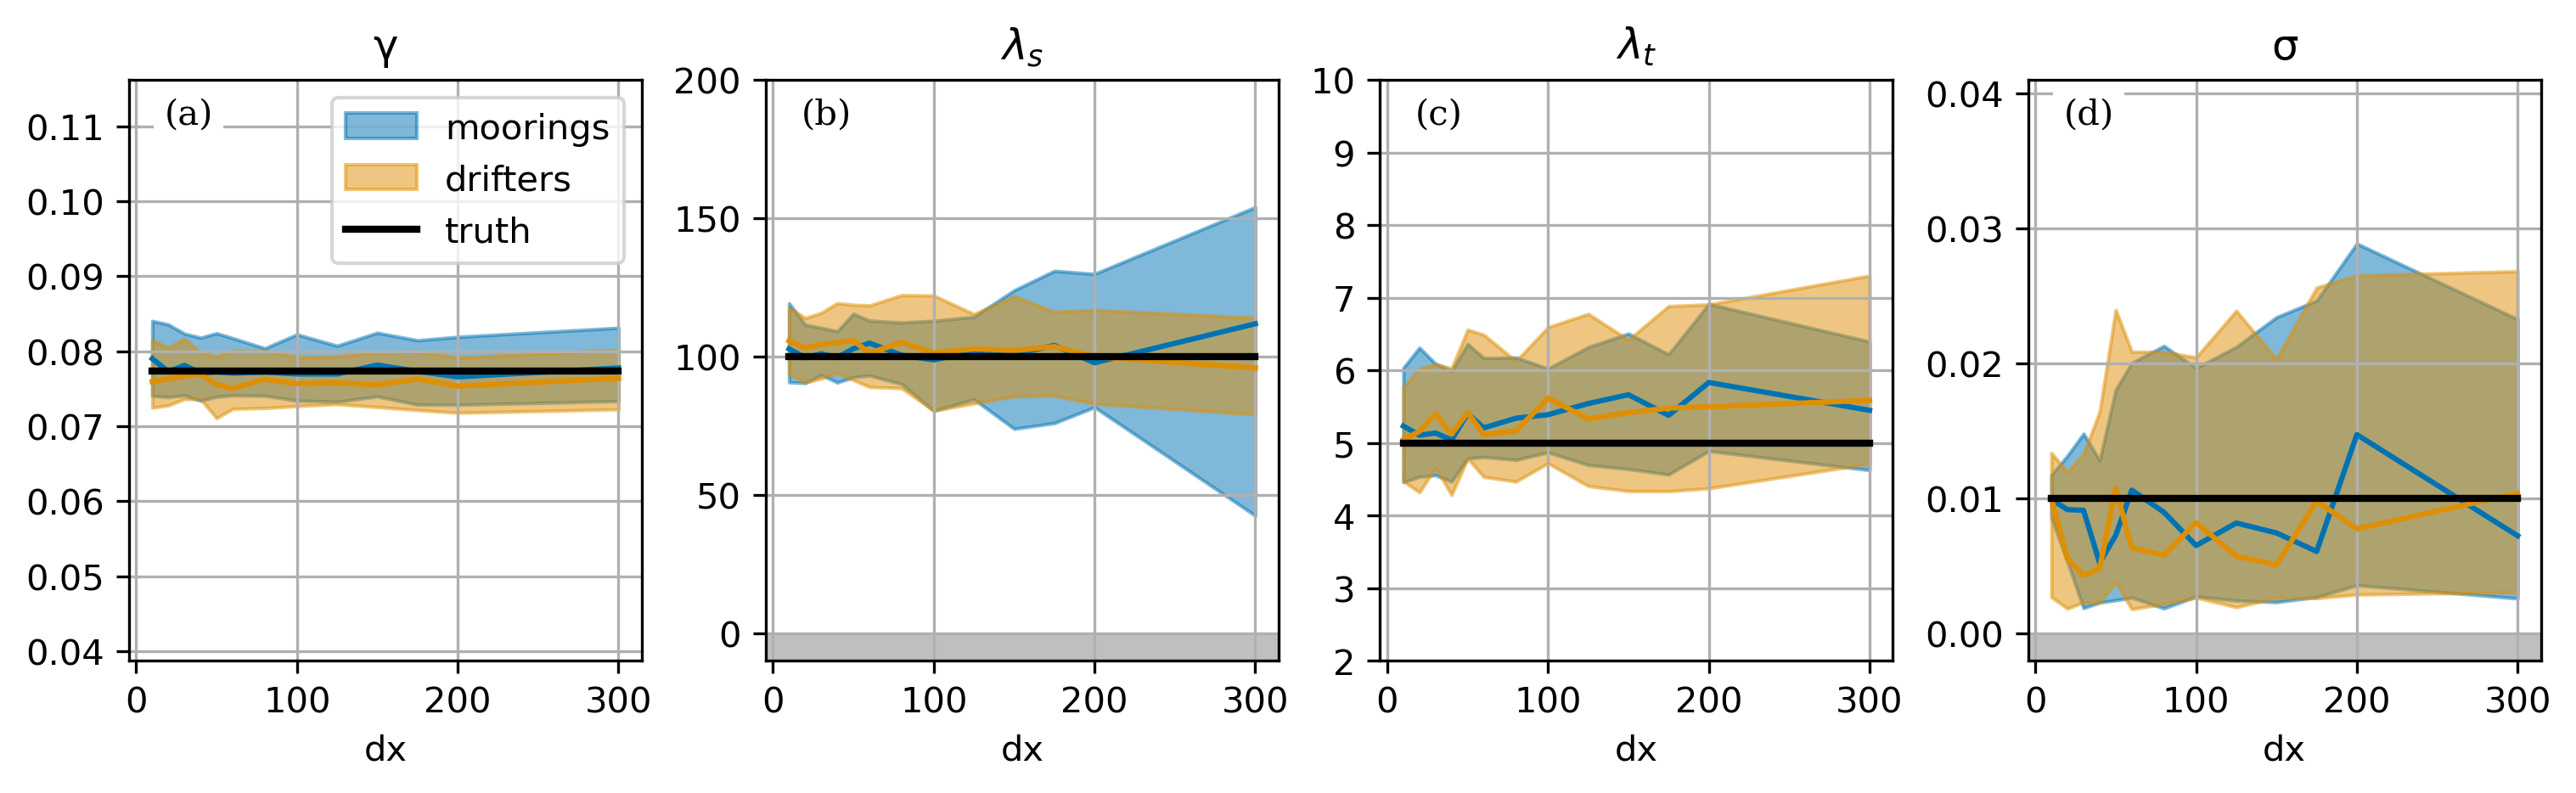

In [17]:
fig, axes = st.plot_sensitivity_combined(dsm, dsr, alpha=0.5, **kw)
st.label_and_print(fig, axes, flow_attrs["cov_x"]+"_dx_MAP")

In [9]:
# print MAP - truth difference along with normalized difference
st.print_MAP_truth_difference(dsr, "dx")

% dx | γ | λx | λt | σ
% 10 | 0.08 / 0.08 | 105.66 / 100.00 | 5.04 / 5.00 | 0.01 / 0.01
% normalized diff | -2.0 | 5.4 | 0.8 | 0.1
% 20 | 0.08 / 0.08 | 103.06 / 100.00 | 5.16 / 5.00 | 0.01 / 0.01
% normalized diff | -1.5 | 3.0 | 3.1 | -80.4
% 30 | 0.08 / 0.08 | 104.35 / 100.00 | 5.40 / 5.00 | 0.00 / 0.01
% normalized diff | -1.0 | 4.2 | 7.4 | -131.9
% 40 | 0.08 / 0.08 | 104.89 / 100.00 | 5.12 / 5.00 | 0.00 / 0.01
% normalized diff | -0.6 | 4.7 | 2.3 | -108.3
% 50 | 0.08 / 0.08 | 105.77 / 100.00 | 5.42 / 5.00 | 0.01 / 0.01
% normalized diff | -2.5 | 5.5 | 7.7 | 7.0
% 60 | 0.08 / 0.08 | 101.15 / 100.00 | 5.11 / 5.00 | 0.01 / 0.01
% normalized diff | -3.3 | 1.1 | 2.2 | -57.7
% 80 | 0.08 / 0.08 | 105.09 / 100.00 | 5.16 / 5.00 | 0.01 / 0.01
% normalized diff | -1.6 | 4.8 | 3.1 | -72.2
% 100 | 0.08 / 0.08 | 101.26 / 100.00 | 5.62 / 5.00 | 0.01 / 0.01
% normalized diff | -2.4 | 1.2 | 11.0 | -21.6
% 125 | 0.08 / 0.08 | 102.75 / 100.00 | 5.33 / 5.00 | 0.01 / 0.01
% normalized diff | -2.2 | 2.7 

In [18]:
st.print_quantile_width(dsm, "dx")
st.print_quantile_width(dsr, "dx")

 | γ | λx | λt | σ
10 | 0.13 | 0.29 | 0.31 | 0.32
20 | 0.12 | 0.21 | 0.36 | 0.79
30 | 0.11 | 0.17 | 0.31 | 1.29
40 | 0.11 | 0.19 | 0.31 | 1.05
50 | 0.11 | 0.23 | 0.32 | 1.56
60 | 0.10 | 0.20 | 0.27 | 1.74
80 | 0.08 | 0.22 | 0.28 | 1.94
100 | 0.11 | 0.33 | 0.23 | 1.69
125 | 0.10 | 0.30 | 0.32 | 1.88
150 | 0.11 | 0.50 | 0.37 | 2.11
175 | 0.11 | 0.55 | 0.33 | 2.19
200 | 0.12 | 0.48 | 0.41 | 2.53
300 | 0.13 | 1.12 | 0.35 | 2.07
 | γ | λx | λt | σ
10 | 0.12 | 0.24 | 0.26 | 1.07
20 | 0.10 | 0.23 | 0.34 | 1.01
30 | 0.10 | 0.24 | 0.28 | 1.10
40 | 0.08 | 0.25 | 0.35 | 1.41
50 | 0.11 | 0.27 | 0.35 | 2.02
60 | 0.10 | 0.29 | 0.39 | 1.90
80 | 0.10 | 0.34 | 0.33 | 1.87
100 | 0.08 | 0.42 | 0.37 | 1.78
125 | 0.08 | 0.32 | 0.47 | 2.19
150 | 0.09 | 0.36 | 0.42 | 1.77
175 | 0.10 | 0.30 | 0.51 | 2.30
200 | 0.10 | 0.34 | 0.51 | 2.36
300 | 0.10 | 0.35 | 0.52 | 2.38


In [ ]:
fig, axes = st.plot_sensitivity_combined(
    dsm, None, label="moorings", alpha=0.5, **kw, 
)

In [ ]:
fig, axes = st.plot_sensitivity_combined(
    dsr, None, label="drifters", c=colors["dr"], alpha=0.5, **kw, 
)

---

## mooring inference plot

In [ ]:
ds = Dm[0]
_ds = ds.sel(ensemble=slice(0,10))
st.traceplots(_ds, MAP=False)
st.plot_inference(_ds, xlim=False)

#### Empirical convergence metrics 

In [6]:
def show_convergence(ds):
    """ split time series in half and compare mean and std"""

    N = ds["i"].size
    ds0 = ds.isel(i=slice(0,N//2))
    ds0m = ds0.mean(["i"])
    ds0std = ds0.std(["i"])
    ds1 = ds.isel(i=slice(N//2,None))
    ds1m = ds1.mean(["i"])
    ds1std = ds1.std(["i"])

    # mean
    fig, axes = plt.subplots(ds.parameter.size,1,figsize=(5,5), sharex=True,)
    for p, ax in zip(ds.parameter.values, axes):
        _da = ds0m.sel(parameter=p).samples
        _da.plot(ax=ax)
        _da = ds1m.sel(parameter=p).samples
        _da.plot(ax=ax)
        ax.set_title(p+" mean")
        if p!=ds.parameter.values[-1]:
            ax.set_xlabel("")
    plt.subplots_adjust(hspace=0.5)

    # mean
    fig, axes = plt.subplots(ds.parameter.size,1,figsize=(5,5), sharex=True,)
    for p, ax in zip(ds.parameter.values, axes):
        _da = ds0std.sel(parameter=p).samples
        _da.plot(ax=ax)
        _da = ds1std.sel(parameter=p).samples
        _da.plot(ax=ax)
        ax.set_title(p+" std")
        if p!=ds.parameter.values[-1]:
            ax.set_xlabel("")
    plt.subplots_adjust(hspace=0.5)

In [ ]:
show_convergence(ds)

#### Effective sample size

In [7]:
samples = ds.samples.isel(ensemble=0).values
samples_az = st.convert_to_az(samples, labels)
Ndof = az.ess(samples_az)
print(Ndof)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    σ        float64 143.1
    γ        float64 387.8
    λx       float64 167.5
    λt       float64 236.9


#### MAP

In [ ]:
fig, axes = plt.subplots(1, ds.parameter.size, figsize=(15,4))

for p, ax in zip(ds.parameter, axes):
    _ds = ds.sel(parameter=p)
    _tr = float(_ds.true_parameters.isel(ensemble=0))
    _ds.MAP.plot.hist(ax=ax, bins=10, color="0.5")
    ax.set_title(str(p.values)) #+ " - MAP"
    ax.axvline(_tr, color="k", lw=4)

#### mean/std

In [ ]:
fig, axes = plt.subplots(2, ds.parameter.size, figsize=(15,4), gridspec_kw=dict(hspace=.5))

# mean
for p, ax in zip(ds.parameter, axes[0,:]):
    _ds = ds.sel(parameter=p).isel(i=slice(burn,None))
    _da = _ds.samples.mean("i")
    _da.plot.hist(ax=ax, bins=10, color="0.5")
    ax.set_title(str(p.values)+" - mean")
    _tr = float(_ds.true_parameters.isel(ensemble=0))
    ax.axvline(_tr, color="k", lw=4)
    ax.set_xlabel("")
    
# std
for p, ax in zip(ds.parameter, axes[1,:]):
    _ds = ds.sel(parameter=p).isel(i=slice(burn,None))
    _da = _ds.samples.std("i")
    _da.plot.hist(ax=ax, bins=10, color="cadetblue")
    ax.set_title(str(p.values)+ " - std")
    _tr = float(_ds.true_parameters.isel(ensemble=0))
    ax.axvline(_tr, color="k", lw=4)
    ax.set_xlabel("")

#### quantiles

In [ ]:
fig, axes = plt.subplots(1, ds.parameter.size, figsize=(15,4))

qt = [0.1, 0.9]

for p, ax in zip(ds.parameter, axes):
    _ds = ds.sel(parameter=p)
    _da = _ds.samples.quantile(qt, dim="i")
    _tr = float(_ds.true_parameters.isel(ensemble=0))
    for q in qt:
        _da.sel(quantile=q).plot.hist(ax=ax, bins=10, alpha=.5, label=f"{q}")
    ax.axvline(_tr, color="k", lw=4)
    ax.set_title(str(p.values))
    ax.set_xlabel("")
    ax.legend()

##### quantiles 0.1 0.9 difference

this larger than std by a factor of about 2

In [ ]:
fig, axes = plt.subplots(1, ds.parameter.size, figsize=(15,4))

qt = [0.1, 0.9]

for p, ax in zip(ds.parameter, axes):
    _ds = ds.sel(parameter=p)
    _da = _ds.samples.quantile(qt, dim="i")
    _tr = float(_ds.true_parameters.isel(ensemble=0))
    _da = _da.sel(quantile=qt[1]) - _da.sel(quantile=qt[0])
    _da.plot.hist(ax=ax, bins=10, color="cadetblue")
    ax.axvline(_tr, color="k", lw=4)
    ax.set_title(str(p.values))
    ax.set_xlabel("")

---
## drifter inference plot

In [ ]:
ds = Dr[0]

_ds = ds.sel(ensemble=slice(0,10))
st.traceplots(_ds, MAP=False)
st.plot_inference(_ds, xlim=False)

#### MAP

The underestimation of $\gamma$ may be related to interference with the noise parameter inference (see joint distributions above) and the fact we allow for substantial values of the noise compared to the $\gamma$ ... to be verified

In [ ]:
fig, axes = plt.subplots(1, ds.parameter.size, figsize=(15,4))

for p, ax in zip(ds.parameter, axes):
    _ds = ds.sel(parameter=p)
    _tr = float(_ds.true_parameters.isel(ensemble=0))
    _ds.MAP.plot.hist(ax=ax, bins=10, color="0.5")
    ax.set_title(str(p.values)) #+ " - MAP"
    ax.axvline(_tr, color="k", lw=4)

#### mean/std

In [ ]:
fig, axes = plt.subplots(2, ds.parameter.size, figsize=(15,4), gridspec_kw=dict(hspace=.5))

# mean
for p, ax in zip(ds.parameter, axes[0,:]):
    _ds = ds.sel(parameter=p).isel(i=slice(burn,None))
    _da = _ds.samples.mean("i")
    _da.plot.hist(ax=ax, bins=10, color="0.5")
    ax.set_title(str(p.values)+" - mean")
    _tr = float(_ds.true_parameters.isel(ensemble=0))
    ax.axvline(_tr, color="k", lw=4)
    ax.set_xlabel("")
    
# std
for p, ax in zip(ds.parameter, axes[1,:]):
    _ds = ds.sel(parameter=p).isel(i=slice(burn,None))
    _da = _ds.samples.std("i")
    _da.plot.hist(ax=ax, bins=10, color="cadetblue")
    ax.set_title(str(p.values)+ " - std")
    _tr = float(_ds.true_parameters.isel(ensemble=0))
    ax.axvline(_tr, color="k", lw=4)
    ax.set_xlabel("")

#### quantiles

In [ ]:
fig, axes = plt.subplots(1, ds.parameter.size, figsize=(15,4))

qt = [0.1, 0.9]

for p, ax in zip(ds.parameter, axes):
    _ds = ds.sel(parameter=p)
    _da = _ds.samples.quantile(qt, dim="i")
    _tr = float(_ds.true_parameters.isel(ensemble=0))
    for q in qt:
        _da.sel(quantile=q).plot.hist(ax=ax, bins=10, alpha=.5, label=f"{q}")
    ax.axvline(_tr, color="k", lw=4)
    ax.set_title(str(p.values))
    ax.set_xlabel("")
    ax.legend()

In [ ]:
fig, axes = plt.subplots(1, ds.parameter.size, figsize=(15,4))

qt = [0.1, 0.9]

for p, ax in zip(ds.parameter, axes):
    _ds = ds.sel(parameter=p)
    _da = _ds.samples.quantile(qt, dim="i")
    _tr = float(_ds.true_parameters.isel(ensemble=0))
    _da = _da.sel(quantile=qt[1]) - _da.sel(quantile=qt[0])
    _da.plot.hist(ax=ax, bins=10, color="cadetblue")
    ax.axvline(_tr, color="k", lw=4)
    ax.set_title(str(p.values))
    ax.set_xlabel("")